# Deep Learning for Communications
By Jakob Hoydis,
Contact [jakob.hoydis@nokia-bell-labs.com](mailto:jakob.hoydis@nokia-bell-labs.com)

This code is provided as supplementary material to the tutorial [Deep Learning for Communications](http://pimrc2018.ieee-pimrc.org/program/tutorials/).    
It is licensed under the GPLv2 license. If you in any way use this code for research that results in publications, please cite it appropriately. 

# Deep Unfolding - Neural Belief Propagation
### In this notebook we show how to interpret the existing belief propagation decoding algorithm as explicite neural network and analyze how to train such a network

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import numpy as np

from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
seed = 1337
tf.set_random_seed(seed)
np.random.seed(seed)

# Problem Description:

The task is to implement the belief propagation decoding algorithm for channel coding and add trainable weights to the edges in the graph.

Can stochastic gradient descent optimize these weights?

# Setting up the scenario
We use pre-generated parity check matrixes (BCH and Polar); see webdemos (and other references given in the lecture):

http://webdemo.inue.uni-stuttgart.de/webdemos/02_lectures/MEC/LDPC_degree_distribution/

http://webdemo.inue.uni-stuttgart.de/webdemos/03_theses/LDPC_Codes_from_Communication_Standards/

In [0]:
#load list of predefined matrices
ParityCheckMatrices = [[[1,0,1,1,1,0,0],[0,1,0,1,1,1,0],[0,0,1,0,1,1,1]],[[1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1]],[[1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1]],[[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],[0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0],[1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],[1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],[0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],[1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],[0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]]

In [0]:
ParityCheck_id = 3   # decide which parity check matrix should be used (0-2: BCH; 3: LDPC)

ParityCheckMatrix = np.array(ParityCheckMatrices[ParityCheck_id])   # load parity-check matrix
n = ParityCheckMatrix.shape[1]   # define number of codeword bits n (codeword length)
k = n-ParityCheckMatrix.shape[0]   # define number of information bits k per codeword
coderate = k/n   # coderate as fraction of information bits per CWs
num_bp_iterations = 10   # number of bp iterations

#print parity-check matrix
print(ParityCheckMatrix)
print('n:{}, k:{}, coderate:{}'.format(n,k,coderate))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
n:100, k:50, coderate:0.5


# Let's analyze the parity-check matrix 
When loading the (7,4) BCH code you should see the well-known (7,4) Hamming code structure (see lecture).

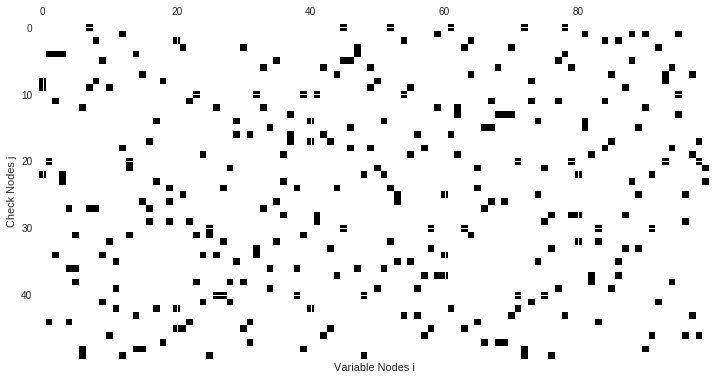

In [0]:
plt.figure(figsize=(12, 8));
plt.xlabel('Variable Nodes i');
plt.ylabel('Check Nodes j');
plt.spy(ParityCheckMatrix);

Each black dot at position (j,i) defines a connection (edge) between VN i and CN j in the corresponding Tanner graph

# Helper functions
Compute the noise variance for a given SNR and coderate.


In [0]:
def ebnodb2noisevar(ebno_db, coderate):
    ebno = 10**(ebno_db/10)
    noise_var = 1/(2*coderate*ebno)  
    return noise_var

Compute LLRs for BPSK from given channel observations.

In [0]:
def compute_llr(y, noise_var):
    return 2*y/noise_var

# Modeling belief propagation as deep neural network
Now we need to create our neural network:

The Graph is defined by the partiy-check matrix H.

H_unconnected defines all unnconnected positions.

Remark: We use dtype=tf.float32 as this is more natural in the GPU environment. However, boolean values (connection yes/no) are sufficient.

In [0]:
H = tf.Variable(ParityCheckMatrix, trainable=False, dtype=tf.float32)
H_unconnected = tf.cast(tf.equal(H, 0), dtype=tf.float32)

Define placeholder for batch size and noise_var (SNR)

In [0]:
batch_size = tf.placeholder_with_default(100, shape=())
noise_var = tf.placeholder_with_default(1.0, shape=())

We use the all-zero CW x of length n (as it is part of any linear code) to avoid encoding.

The channel is a simple AWGN channel with noise variance "noise_var".

Finally, the channel output y is y=x+n.

In [0]:
x = tf.ones(shape=[n], dtype=tf.float32)
noise = tf.random_normal(shape=[batch_size, n], stddev=tf.sqrt(noise_var))
y = x + noise

### Define VN to CN messages

The LLR values are clipped such that the absolute value of each message is not larger than 10.
In this Notebook we only train weights of messages from VNs to CNs, but extensions are straightforward.
The messages are initialized with 1 (rather than a random initalization).

### Define CN to VN messages

The CN update requires message clipping due to numerical stability of the CN update function

In [0]:
def var_to_check(cv, H, llr, init=False, final=False):
    if init: #first layer
        # Simply send channel llrs along the edges 
        vc = tf.transpose(tf.expand_dims(H, axis=0)*tf.expand_dims(llr, axis=1), perm=[0,2,1])
        vc = tf.nn.tanh(tf.clip_by_value(1/2*vc, clip_value_min=-9.9, clip_value_max=9.9))
        return vc, vc
    else:
        shape_cv = cv.get_shape().as_list()
        shape_llr = llr.get_shape().as_list()
        W_c = tf.Variable(initial_value=tf.ones(shape=[1, shape_cv[1], shape_cv[2]]), trainable=True,dtype=tf.float32)
        cv *= W_c
    if final: # last layer (marginalization)
        # Final marginalization
        vc = tf.reduce_sum(cv, axis=1)+llr
        return vc, vc
    else: 
        # Sum-up messages, add llr, and substract message for relative edge
        vc = tf.reduce_sum(cv, axis=1)+llr
        vc = tf.expand_dims(H, axis=0)*tf.expand_dims(vc, axis=1) - cv
        vc = tf.transpose(vc, perm=[0,2,1])
        vc = tf.nn.tanh(tf.clip_by_value(1/2*vc, clip_value_min=-9.9, clip_value_max=9.9))
        return vc, tf.reduce_sum(cv, axis=1)+llr

In [0]:
def check_to_var(vc, H, H_unconnected):
    vc_tanh = tf.transpose(vc, perm=[0,2,1])
    cv = tf.reduce_prod(vc_tanh + H_unconnected, axis=2, keepdims=True)
    cv = tf.where(tf.equal(cv,0),tf.ones_like(cv)*1e-12,cv)
    cv = (cv/(vc_tanh+H_unconnected))*tf.expand_dims(H, axis=0)
    cv = tf.clip_by_value(cv, clip_value_min=-1+1e-6, clip_value_max=1-1e-6)
    cv = 2*tf.atanh(cv)
    return cv

## Define the neural network
In total num_bp_iterations are performaned. The all zero CW is used (as it is part of any linear code).

In the first iteration there are no previous messages and, thus, only the channel observations (llr) are used as input (rather than pre-initalizing a previous layer with 0).

The last layer performs a final marginalization step, i.e., it sums ob all incoming messages at the VN.

In [0]:
cv = tf.zeros(shape=[batch_size,n-k,n])
llr = compute_llr(y, noise_var)
loss = 0

for i in range(num_bp_iterations):
    is_final = (i==num_bp_iterations-1)
    is_init = (i==0)
    vc, logits = var_to_check(cv, H, llr, init=is_init, final=is_final)    
    if not is_final:
        cv = check_to_var(vc, H, H_unconnected)
    if not is_init:
        loss += tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones(shape=[batch_size, n]), logits=logits)

loss /= num_bp_iterations
x_hat = tf.cast(tf.greater(tf.nn.sigmoid(vc), 0.5), dtype=tf.float32)
ber = tf.reduce_mean(tf.cast(tf.not_equal(x, x_hat), dtype=tf.float32))
W_total = tf.global_variables()     #for weigth distribution histograms

### Define ADAM optimizer with apply gradient clipping

In [0]:
optimizer = tf.train.AdamOptimizer(1e-3)
grads_and_vars = optimizer.compute_gradients(loss)
grads_and_vars = [(tf.clip_by_value(g, -10, 10), v) for g,v in grads_and_vars]
step = optimizer.apply_gradients(grads_and_vars)

### Start new Session

In [0]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Evaluate belief propagation decoding (without training)
As all of the weights are initialized with 1, the inital performance of the neural networks equals the performance of the conventional BP decoder.

For the Monte-Carlo BER simulations batches of size "samples" are transmitted and decoded one-shot. This is repeated "iterations" times, i.e., in total "samples*iterations" codewords are simulated per SNR point.

See http://webdemo.inue.uni-stuttgart.de/webdemos/08_research/GPU_LDPC_Decoder/index.php for reference curves.

In [0]:
samples = 10000
epochs = 10
ebnos_db = np.linspace(1,6, 6)
bers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        bers_no_training[i] += sess.run(ber, feed_dict={
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
bers_no_training /= epochs

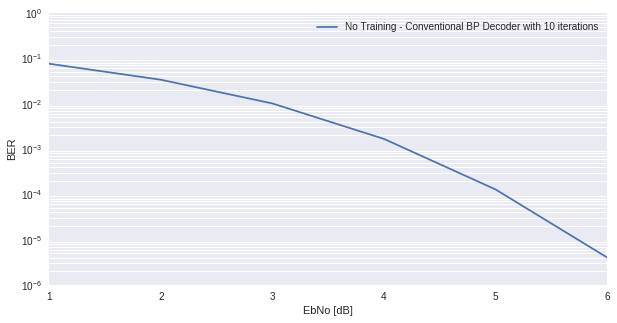

In [0]:
plt.figure(figsize=(10, 5))
plt.semilogy(ebnos_db, bers_no_training, '-x')
plt.grid(which='both');
plt.xlabel('EbNo [dB]');
plt.ylabel('BER');
plt.ylim([1e-6, 1e-0]);
plt.xlim([ebnos_db[0], ebnos_db[-1]]);
plt.legend(['No Training - Conventional BP Decoder with %d iterations' % (num_bp_iterations)]);

### Check whether all weights are properly initalized

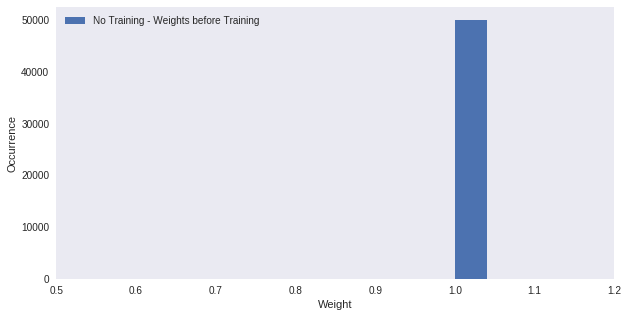

In [0]:
w=sess.run(W_total, feed_dict={})  #get all weights from the graph and use flatten for the histogram function
Wuntrained=w[1].flatten()#shkip first variable (as this is the parity-check matrix)
for i in range(1,len(w)):
    Wuntrained=np.concatenate((w[i].flatten(),Wuntrained),axis=0)
plt.figure(figsize=(10, 5));
plt.hist(Wuntrained,bins=40,range=(-0.2, 1.4))
plt.grid(which='both');
plt.xlabel('Weight');
plt.ylabel('Occurrence');
plt.xlim([0.5, 1.2]);
plt.legend(['No Training - Weights before Training']);

All weights are properly set to 1.

# Train the neural network 

We now train the neural belief propagation decoder in the same way as we trained previous neural networks, i.e., by using stochastic-gradient descent. We print intermediate BER values to track the progress. However, this information is not used for training at any time.

In [0]:
train_ebno_db = 4
for it in range(2000):
    feed_dict = {
        batch_size: 100,
        noise_var: ebnodb2noisevar(train_ebno_db, coderate)
    }
    sess.run(step, feed_dict=feed_dict)
    
    #provide intermediate BER metric (not used for training!)
    if (it%100==0):
        feed_dict = {
        batch_size: 10000,
        noise_var: ebnodb2noisevar(train_ebno_db, coderate)
    }
        l, b = sess.run([loss, ber], feed_dict=feed_dict)
        print(it, "Loss: {}, BER: {:.2E}".format(l, b))

0 Loss: 0.017477035522460938, BER: 1.84E-03
100 Loss: 0.01591726765036583, BER: 1.56E-03
200 Loss: 0.014707371592521667, BER: 1.22E-03
300 Loss: 0.013060949742794037, BER: 8.93E-04
400 Loss: 0.012559709139168262, BER: 9.30E-04
500 Loss: 0.013218007981777191, BER: 9.65E-04
600 Loss: 0.012431609444320202, BER: 9.83E-04
700 Loss: 0.011599212884902954, BER: 7.68E-04
800 Loss: 0.011895936913788319, BER: 7.71E-04
900 Loss: 0.01183926872909069, BER: 7.75E-04
1000 Loss: 0.011648500338196754, BER: 7.71E-04
1100 Loss: 0.010606283321976662, BER: 5.89E-04
1200 Loss: 0.010871530510485172, BER: 6.27E-04
1300 Loss: 0.011259777471423149, BER: 7.82E-04
1400 Loss: 0.010541445575654507, BER: 6.45E-04
1500 Loss: 0.010323980823159218, BER: 6.23E-04
1600 Loss: 0.010380217805504799, BER: 5.15E-04
1700 Loss: 0.010339614935219288, BER: 6.35E-04
1800 Loss: 0.009862923063337803, BER: 4.91E-04
1900 Loss: 0.009930497035384178, BER: 4.91E-04


# And evaluate the performance of the trained decoder
Now we evaluate the BER performance of the trained BP decoder

In [0]:
samples = 10000
epochs = 10
ebnos_db = np.linspace(1,6, 6)
bers = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        bers[i] += sess.run(ber, feed_dict={
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
bers /= epochs

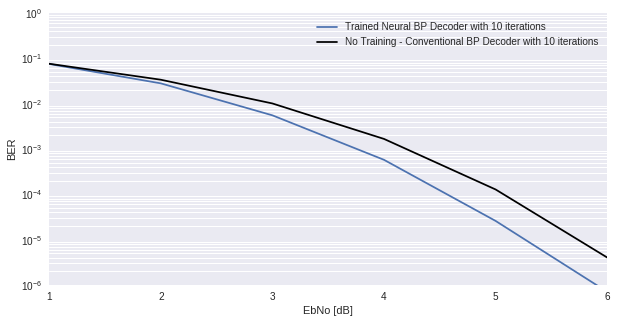

In [0]:
plt.figure(figsize=(10, 5))
plt.semilogy(ebnos_db, bers, '-x')
plt.semilogy(ebnos_db, bers_no_training, '-0')#use previously stored BER
plt.grid(which='both');
plt.xlabel('EbNo [dB]');
plt.ylabel('BER');
plt.ylim([1e-6, 1e-0]);
plt.xlim([ebnos_db[0], ebnos_db[-1]]);
plt.legend(['Trained Neural BP Decoder with %d iterations' % (num_bp_iterations),'No Training - Conventional BP Decoder with %d iterations' % (num_bp_iterations)]);
#plt.savefig('ber.pdf', bbox_inches='tight'); #create plots for the lecture slides

As can be seen the decoder improves by approximately 0.5 dB. Keep in mind that the used LDPC code is very short (n=100; tpyically n>1000 bits per codeword) and not well-designed. For well-designed LDPC codes from existing standards (to the best of our knowledgeg) no further gains can be observed.

# Plot the Histogram of the Trained Weights

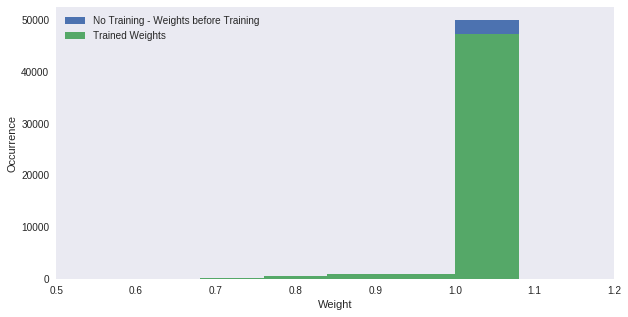

In [0]:
w=sess.run(W_total, feed_dict={})  #get all weights from the graph and use flatten for the histogram function
Wtrained=w[1].flatten()#shkip first variable (as this is the parity-check matrix)
for i in range(1,len(w)):
    Wtrained=np.concatenate((w[i].flatten(),Wtrained),axis=0)
plt.figure(figsize=(10, 5));
plt.hist(Wuntrained,bins=20, range=(-0.2, 1.4))#use previously stored weights
plt.hist(Wtrained,bins=20, range=(-0.2, 1.4))
plt.grid(which='both');
plt.xlabel('Weight');
plt.ylabel('Occurrence');
plt.xlim([0.5, 1.2]);
plt.legend(['No Training - Weights before Training','Trained Weights']);
#plt.savefig('hist.pdf', bbox_inches='tight');   #create plots for the lecture slides

We observe that the weigths tend to be smaller, i.e., edges are (partly) removed from the Tanner graph